In [1]:
# data analysis
import numpy as np
import pandas as pd
import sys
import glob

# plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [8,6]

import warnings
warnings.filterwarnings('ignore')

In [2]:
# setup IO

datadir = '/home/lukas/projects/antibiotics/experiments/200129_AllData/'


# helper routines and estimators

def FunctionMueff(itau, phi = 1, mu0 = 1):
    return mu0*(1 + phi**2 * itau**2)

def ComputeR2(listmu,listinvtau,mu0,phi):
    yi    = np.log(listmu)
    fi    = np.log(FunctionMueff(listinvtau,phi,mu0))
    ymean = np.mean(yi)
    
    ssres = np.sum((yi-fi)**2)
    sstot = np.sum((yi-ymean)**2)
    
    return 1. - ssres/sstot


def ComputePhiMu0(listmu, listinvtau, mu0mask):
    listmu0 = np.select(mu0mask,listmu)
    mu0     = np.mean(listmu0)
    phi     = np.power(np.sqrt(np.prod(listmu))/np.prod(listinvtau),1./len(listinvtau))/np.sqrt(mu0)
    
    return phi,mu0


# initialize variables

methods = ['std','binarized','nonbinarized']
names   = ['andy','philip']
mueff   = {}
invtau  = {}
mu0mask = {}

#std          mu0_andy   = 5.748463e-02
#std          phi_andy   = 2.747633e+06
#std          R2_andy    = 0.693005

#std          mu0_philip = 6.371377e-02
#std          phi_philip = 1.235120e+06
#std          R2_philip  = 0.350529

#std          mu0_both   = 5.748463e-02
#std          phi_both   = 2.037019e+06
#std          R2_both    = 0.474956



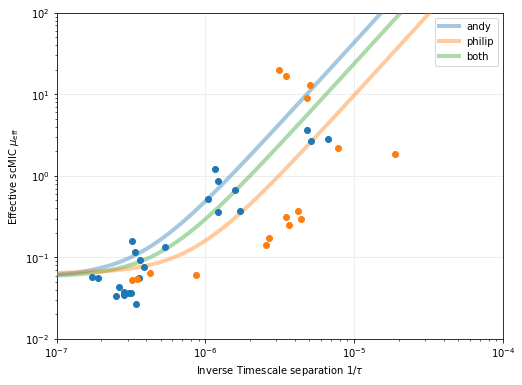

#binarized    mu0_andy   = 5.898177e-02
#binarized    phi_andy   = 2.657386e+06
#binarized    R2_andy    = 0.609603

#binarized    mu0_philip = 5.968016e-02
#binarized    phi_philip = 1.260075e+06
#binarized    R2_philip  = 0.432972

#binarized    mu0_both   = 5.898177e-02
#binarized    phi_both   = 1.976304e+06
#binarized    R2_both    = 0.473996



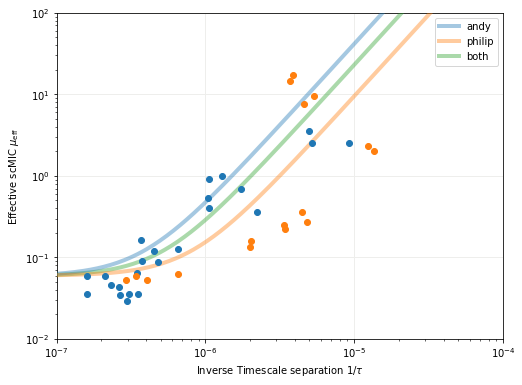

#nonbinarized mu0_andy   = 8.920250e-02
#nonbinarized phi_andy   = 2.328885e+06
#nonbinarized R2_andy    = 0.509907

#nonbinarized mu0_philip = 9.867409e-02
#nonbinarized phi_philip = 7.698439e+05
#nonbinarized R2_philip  = 0.598454

#nonbinarized mu0_both   = 8.920250e-02
#nonbinarized phi_both   = 1.526213e+06
#nonbinarized R2_both    = 0.431386



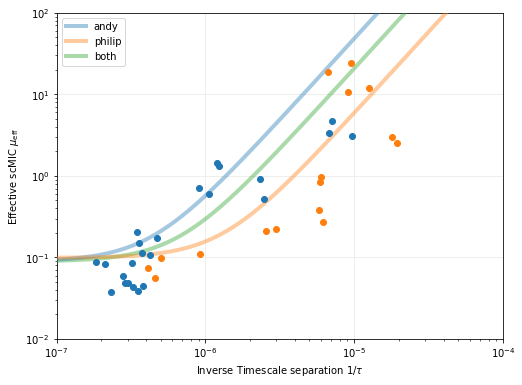

In [12]:
############################
### compute phi & R2     ###
############################


for method in methods:
    
    mueff[method]   = {}
    invtau[method]  = {}
    mu0mask[method] = {}
    
    for name in names:

        mueff[method][name]   = np.array([], dtype = np.float)
        invtau[method][name]  = np.array([], dtype = np.float)
        mu0mask[method][name] = np.array([], dtype = np.bool)

        for fn in glob.glob(datadir + name + '/' + name + '_*/estimateMSP.' + method + '*'):
            a = np.genfromtxt(fn)
            if len(a) > 0:
                
                if ('WT' in fn and name == 'andy') or ('None' in fn and name == 'philip'):
                    mu0mask[method][name] = np.concatenate([mu0mask[method][name], np.repeat([True], repeats = len(a[:,1]))])
                else:
                    mu0mask[method][name] = np.concatenate([mu0mask[method][name], np.repeat([False], repeats = len(a[:,1]))])
                
                mueff[method][name]       = np.concatenate([mueff[method][name],  a[:,1]], axis = 0)
                invtau[method][name]      = np.concatenate([invtau[method][name], a[:,3]], axis = 0)
        
        phi,mu0 = ComputePhiMu0(mueff[method][name], invtau[method][name], mu0mask[method][name])
        r2      = ComputeR2    (mueff[method][name], invtau[method][name], mu0, phi)

        print('#{:12s} mu0_{:6s} = {:.6e}'.format(method,name,mu0))
        print('#{:12s} phi_{:6s} = {:.6e}'.format(method,name,phi))
        print('#{:12s} R2_{:6s}  = {:.6f}'.format(method,name,r2))
        print()
        
        itaurange = np.exp(np.linspace(np.log(1e-7),np.log(1e-4), num = 200))
        plt.scatter(invtau[method][name], mueff[method][name], zorder = 103)
        plt.plot(itaurange,FunctionMueff(itaurange,phi,mu0),zorder = 102,lw = 4, alpha = .4)
    
    phiavg,mu0avg = ComputePhiMu0(np.concatenate([mueff[method][n] for n in names]), np.concatenate([invtau[method][n] for n in names]), np.concatenate([mu0mask[method][n] for n in names]))
    r2avg         = ComputeR2    (np.concatenate([mueff[method][n] for n in names]), np.concatenate([invtau[method][n] for n in names]), mu0avg, phiavg)
    
    plt.plot(itaurange,FunctionMueff(itaurange,phiavg,mu0avg), zorder = 101, lw = 4, alpha = .4)
    
    print('#{:12s} mu0_{:6s} = {:.6e}'.format(method,'both',mu0avg))
    print('#{:12s} phi_{:6s} = {:.6e}'.format(method,'both',phiavg))
    print('#{:12s} R2_{:6s}  = {:.6f}'.format(method,'both',r2avg))
    print()

    plt.legend(names + ['both'])
    plt.yscale('log')
    plt.ylim([1e-2,1e2])
    plt.xscale('log')
    plt.xlim([1e-7,1e-4])
    plt.grid(c = '#eeeeec', lw =1)
    plt.xlabel(r'Inverse Timescale separation $1/\tau$')
    plt.ylabel(r'Effective scMIC $\mu_\mathrm{eff}$')
    plt.show()